<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Baselines" data-toc-modified-id="Baselines-1">Baselines</a></span><ul class="toc-item"><li><span><a href="#Test" data-toc-modified-id="Test-1.1">Test</a></span><ul class="toc-item"><li><span><a href="#Motivation" data-toc-modified-id="Motivation-1.1.1">Motivation</a></span></li></ul></li></ul></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-2">Prepare data</a></span><ul class="toc-item"><li><span><a href="#Limit-for-a-smaller-area" data-toc-modified-id="Limit-for-a-smaller-area-2.1">Limit for a smaller area</a></span></li><li><span><a href="#Round-time" data-toc-modified-id="Round-time-2.2">Round time</a></span></li><li><span><a href="#Number-of-requests" data-toc-modified-id="Number-of-requests-2.3">Number of requests</a></span></li><li><span><a href="#Create-grid" data-toc-modified-id="Create-grid-2.4">Create grid</a></span><ul class="toc-item"><li><span><a href="#Area-size" data-toc-modified-id="Area-size-2.4.1">Area size</a></span></li><li><span><a href="#Cells" data-toc-modified-id="Cells-2.4.2">Cells</a></span></li></ul></li><li><span><a href="#Number-of-requests-per-hour" data-toc-modified-id="Number-of-requests-per-hour-2.5">Number of requests per hour</a></span></li><li><span><a href="#Create-a-demand-dataset" data-toc-modified-id="Create-a-demand-dataset-2.6">Create a demand dataset</a></span><ul class="toc-item"><li><span><a href="#Demand-dataset" data-toc-modified-id="Demand-dataset-2.6.1">Demand dataset</a></span></li><li><span><a href="#Create-a-grid" data-toc-modified-id="Create-a-grid-2.6.2">Create a grid</a></span></li></ul></li><li><span><a href="#Remove-noise" data-toc-modified-id="Remove-noise-2.7">Remove noise</a></span></li></ul></li></ul></div>

# Baselines

## Test
### Motivation

Create a set of baselines for demand prediction using conventional methods:

* time series prediction
* per cell prediction using any type of regressor, e.g. gradient boosting regressor

# Prepare data

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [129]:
%%time 

raw_data = pd.read_feather('../data/train_data.feather')

print(f'Dataset shape: {raw_data.shape}\n')
raw_data.head(3)

Dataset shape: (41988051, 8)

CPU times: user 2.04 s, sys: 9.23 s, total: 11.3 s
Wall time: 27.3 s


,pickup_datetime,dropoff_datetime,passenger_count,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2015-01-01 00:00:00,2015-01-01 00:00:00,3,2.510570,-74.001320,40.729057,-74.010208,40.719662
1,2015-01-01 00:00:03,2015-01-01 00:10:50,1,2.542757,-73.987579,40.765270,-73.976921,40.776970
2,2015-01-01 00:00:03,2015-01-01 00:21:48,2,4.136004,-73.969017,40.754269,-73.994133,40.761600


In [130]:
raw_data.drop(['dropoff_datetime', 'passenger_count', 'distance',
           'dropoff_lon', 'dropoff_lat'], axis=1, inplace=True)

raw_data.columns = ['datetime', 'lon', 'lat']

raw_data.head(3)

,datetime,lon,lat
0,2015-01-01 00:00:00,-74.001320,40.729057
1,2015-01-01 00:00:03,-73.987579,40.765270
2,2015-01-01 00:00:03,-73.969017,40.754269


## Limit for a smaller area

Use area selected manually using http://geojson.io/#map=15/40.7357/-73.9889

In [131]:
bbox = ((-73.996, -73.9817), (40.7308, 40.7416))

(min_lon, max_lon), (min_lat, max_lat) = bbox

idx = (data.lat >= min_lat) & (data.lat <= max_lat)
idx = idx & (data.lon >= min_lon) & (data.lon <= max_lon)

print(f'Dataset size: {raw_data.shape[0]}')
print(f'Sample size: {idx.sum()}')

data = raw_data[idx].reset_index(drop=True);

Dataset size: 41988051
Sample size: 2750089


Demand per day stats:

In [132]:
data.datetime.dt.date.value_counts().describe()

count      120.000000
mean     22917.408333
std       3606.016374
min       7588.000000
25%      21055.500000
50%      23054.000000
75%      25072.500000
max      32858.000000
Name: datetime, dtype: float64

## Round time

In [133]:
data.datetime = data.datetime.dt.round('10min')

data.sample(5)

,datetime,lon,lat
580314,2015-01-26 16:00:00,-73.989235,40.734192
776683,2015-02-04 21:30:00,-73.991020,40.737991
1385914,2015-03-01 15:00:00,-73.994812,40.739868
264424,2015-01-13 12:30:00,-73.988190,40.737839
1693652,2015-03-15 03:50:00,-73.985069,40.732456


Create a grid and count the *number of requests per cell*

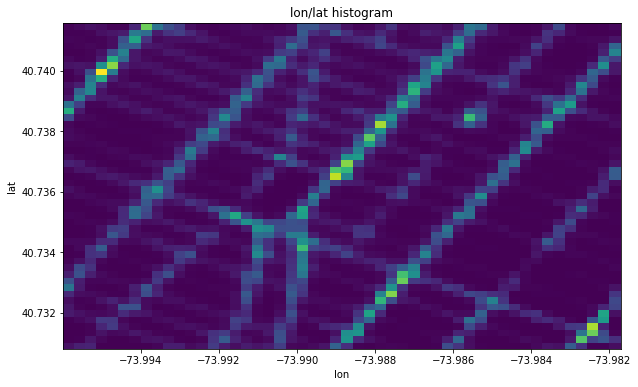

In [138]:
plt.figure(figsize=(10, 6))

plt.hist2d(data.lon, data.lat, bins=50);
plt.title('lon/lat histogram');
plt.xlabel('lon');
plt.ylabel('lat');

## Number of requests

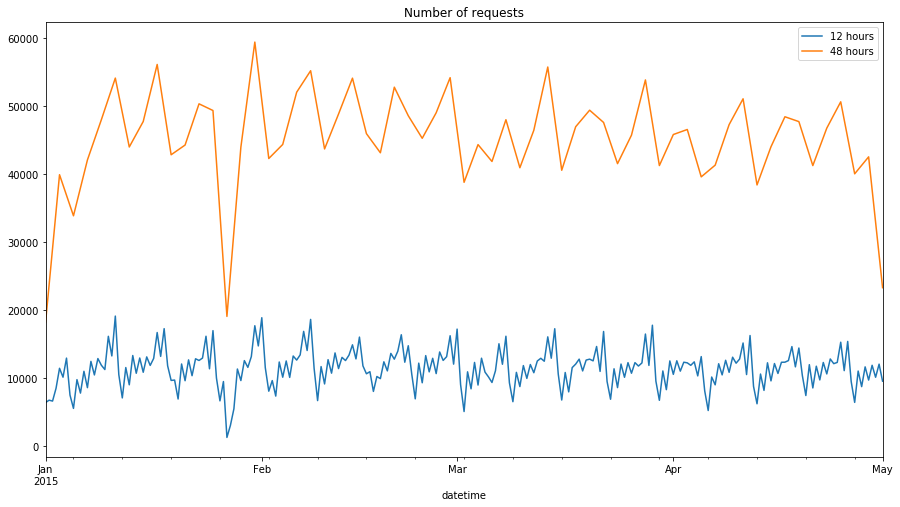

In [187]:
plt.figure(figsize=(15, 8))

plt.title('Number of requests')
data.groupby(data.datetime.dt.round('12h')).datetime.count().plot(label='12 hours')
data.groupby(data.datetime.dt.round('48h')).datetime.count().plot(label='48 hours')
plt.legend();

## Create grid

### Area size

In [221]:
import haversine

point1 = (bbox[1][0], bbox[0][0])
point2 = (bbox[1][0], bbox[0][1])
point3 = (bbox[1][1], bbox[0][0])

dx = haversine.haversine(point1, point2)
dy = haversine.haversine(point1, point3)

print(f'Area size is {dx:.2f} x {dy:.2f} km')

Area size is 1.20 x 1.20 km


### Cells

Create 50x50 meters cells

In [222]:
# cell_size x cell_size grid
cell_size = 24

xcells = np.linspace(bbox[0][0], bbox[0][1], cell_size)
data['x_cell'] = np.digitize(data.lon, xcells)

ycells = np.linspace(bbox[1][0], bbox[1][1], cell_size)
data['y_cell'] = np.digitize(data.lat, ycells)

data['cell'] = data.apply(
    lambda item: '{}-{}'.format(item.x_cell, item.y_cell), axis=1)

data.head(5)

,datetime,lon,lat,x_cell,y_cell,cell
0,2015-01-01,-73.986000,40.740601,17,21,17-21
1,2015-01-01,-73.990891,40.738850,9,18,9-18
2,2015-01-01,-73.990509,40.735027,9,10,9-10
3,2015-01-01,-73.987442,40.733410,14,6,14-6
4,2015-01-01,-73.985779,40.731773,17,3,17-3


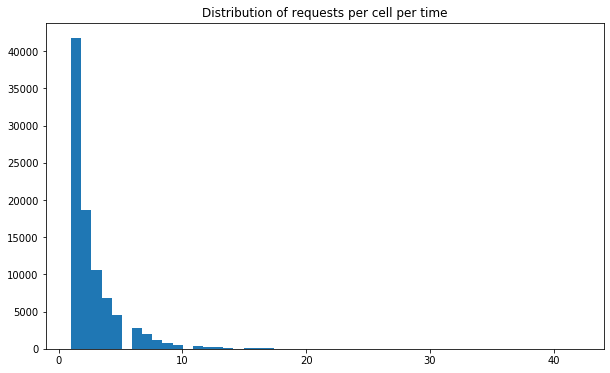

In [226]:
plt.figure(figsize=(10, 6))

plt.title('Distribution of requests per cell per time step')
plt.hist(demand_data.groupby(['datetime', 'cell']).cell.count(), bins=50);

## Number of requests per hour

## Create a demand dataset

* remove all data outside of the prediction area
* remove unnecessary columns
* create a grid and map each data point to a cell of the grid

### Demand dataset

In [ ]:
demand_data = data[
    (data.pickup_lon >= sample_box[0][0]) &
    (data.pickup_lon <= sample_box[0][1]) &
    (data.pickup_lat >= sample_box[1][0]) &
    (data.pickup_lat <= sample_box[1][1])
]

demand_data = demand_data[['pickup_datetime', 'pickup_lon', 'pickup_lat']]
demand_data.columns = ['datetime', 'lon', 'lat']

demand_data.datetime = demand_data.datetime.dt.round('30min')

demand_data.head(3)

### Create a grid

In [ ]:
# cell_size x cell_size grid
cell_size = 20

xcells = np.linspace(sample_box[0][0], sample_box[0][1], cell_size)
demand_data['x_cell'] = np.digitize(demand_data.lon, xcells)

ycells = np.linspace(sample_box[1][0], sample_box[1][1], cell_size)
demand_data['y_cell'] = np.digitize(demand_data.lat, ycells)

demand_data['cell'] = demand_data.apply(
    lambda item: '{}-{}'.format(item.x_cell, item.y_cell), axis=1)

demand_data.head(5)

## Remove noise

It doesn't make sense to predict demand in cells with very low number of requests. The question what level of demand is *low*?

From a business point of view, for example a taxi company, it is important to predict locations and level of high demand, not areas with few requests per day.

In [ ]:
plt.figure(figsize=(20, 7))

date = pd.to_datetime('2015-01-09')
idx = demand_data.datetime.dt.date == date

agg_demand = demand_data[idx].groupby('cell').cell.count()

plt.subplot(121)
plt.title(f'Requests per cell on {date}')
plt.hist(agg_demand, bins=100)
plt.xlabel('Num requests')

plt.subplot(122)
plt.boxplot(agg_demand, meanline=True)
plt.title(f'Requests on {date}')
plt.ylabel('Num requests');

Detect areas with high demand per day, check how demand changes in those areas during some period of time

In [ ]:
agg_demand.describe()

In [ ]:
plt.hist(demand_data.groupby(['datetime', 'cell']).cell.count(), bins=50);